# Sentiment Analysis Using Bidirectional LSTM
## Part I: Research Question

## A. Purpose of Data Analysis

### **Research Question:**

How effectively can we classify customer reviews as positive or negative using neural network models and NLP techniques, enabling a business to understand customer sentiment and improve customer service?

**Context:**

In today's age of social media and online transactions, handling customer feedback effectively is essential for businesses to thrive. Sentiment analysis is a tool that automatically categorizes text data into sentiments, providing valuable insights into customer opinions. This analysis enables organizations to make informed decisions to improve customer experience and satisfaction.

### **Objectives and Goals**
**Objectives:**

- Develop a neural network that accurately classifies text into positive or negative sentiment categories.
- Achieve a validation accuracy of at least 75% while maintaining a low validation loss, indicating good generalization to unseen data.
  
**Goals:**

- Preprocess and clean the text data to ensure high-quality inputs for the model.
- Evaluate different model architectures and select the best performance on the validation set.
- Leverage techniques like regularization and dropout to prevent overfitting and enhance model generalization.

### **Type of Neural Network:**

The model used for this text classification task is a Bidirectional Long Short-Term Memory (LSTM) neural network. This architecture can capture dependencies in text sequences from both forward and backward directions, making it well-suited for sentiment analysis.

## Part II: Data Preparation

## Data Cleaning Process

**Development Environment**

This notebook was developed and tested using the following environment and tools:

- **Jupyter Notebook**: Provides an interactive interface for running code and displaying results.
- **Python Version**: 3.11.9 | packaged by Anaconda, Inc.
- **Key Libraries**: listed below

In [1]:
# pip install -r requirements.txt

In [2]:
# Standard libraries
import random
import re
import warnings

# Data processing and numerical operations
import numpy as np
import pandas as pd

# Text processing and NLP
import contractions
import emoji
import ftfy
from ftfy import fix_and_explain
import nltk
import textstat
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Machine Learning
from sklearn.model_selection import train_test_split

# Neural Network and Training
import tensorflow as tf
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib_inline.backend_inline import set_matplotlib_formats

# Configuration and setup
set_matplotlib_formats('svg')
sns.set_style("darkgrid")
sns.set_context("notebook")
nltk.download('punkt', quiet=True)
warnings.filterwarnings("ignore")

# Increase the column width for better pandas DataFrame readability
pd.set_option('display.max_colwidth', None)


## Data Description

For this analysis, we utilize the "Sentiment Labelled Sentences" dataset from the UCI Machine Learning Repository. This dataset, compiled by Dimitrios Kotzias (2015), includes sentences labeled as positive or negative, sourced from three different domains: IMDB, Amazon, and Yelp. 

In [3]:
# Importing the data from Amazon, IMDB, and YeLp.
amazon = pd.read_csv('amazon_cells_labelled.txt', delimiter='\t',
                     header=None, names=['review', 'sentiment'])
amazon['site'] = 'Amazon'
imdb = pd.read_csv('imdb_labelled.txt', delimiter='\t',
                   header=None, names=['review', 'sentiment'])
imdb['site'] = 'IMDB'
yelp = pd.read_csv('yelp_labelled.txt', delimiter='\t',
                   header=None, names=['review', 'sentiment'])
yelp['site'] = 'Yelp'

**Combining Datasets**

A well-trained model using diverse and high-quality data can better handle complex text than a model trained on less diverse data. While the given datasets consist of reviews, combining them will introduce a little diversity because they cover various products and services.

In [4]:
# Combining all three datasets using concatenate
df = pd.concat([amazon, imdb, yelp], ignore_index=True)

In [5]:
# df.to_csv('combined_data.csv', index=False)

### **Exploratory Data Analysis**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     2748 non-null   object
 1   sentiment  2748 non-null   int64 
 2   site       2748 non-null   object
dtypes: int64(1), object(2)
memory usage: 64.5+ KB


**Missing Values:**
- No missing values are in any of the columns, which simplifies the data preparation process.

**Unique and Duplicate Reviews:**
- Remove duplicate reviews to ensure each review is unique.  

In [7]:
print(f"Number of unique reviews: {df['review'].nunique()}")

Number of unique reviews: 2731


There are 2,731 unique reviews out of 2,748 total entries, indicating the presence of some duplicate reviews.

In [8]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2731 entries, 0 to 2747
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     2731 non-null   object
 1   sentiment  2731 non-null   int64 
 2   site       2731 non-null   object
dtypes: int64(1), object(2)
memory usage: 85.3+ KB


#### **Presence of Unusual Characters:**

The dataset contains some unusual characters such as emojis and special symbols. These characters are removed during preprocessing to focus on textual content.

In [9]:
def find_text_issues(df, text_column):
    # Initialize a dictionary to store
    issues = {}

    # Find URLs in the text
    issues['urls'] = df[text_column].str.contains(r'http\S+').sum()

    # Find digits in the text
    issues['digits'] = df[text_column].str.contains(r'\d').sum()

    # Find non-English characters in the text
    issues['non_english_characters'] = df[text_column].str.contains(
        r'[^a-zA-Z\s]').sum()

    # Find whitespace issues in the text
    issues['whitespace_issues'] = df[text_column].str.contains(r'\s+').sum()

    # Find leading/trailing whitespace issues in the text
    issues['leading_trailing_whitespace'] = df[text_column].str.contains(
        r'^\s+|\s+$').sum()

    # Find newline characters in the text
    issues['newline_characters'] = df[text_column].str.contains(
        r'[\n\r]').sum()

    # Find carriage return characters in the text
    issues['carriage_return_characters'] = df[text_column].str.contains(
        r'\r').sum()

    # Find tab characters in the text
    issues['tab_characters'] = df[text_column].str.contains(r'\t').sum()

    # Find contractions in the text
    issues['contractions'] = df[text_column].str.contains(
        r"[a-z]+['’][a-z]+").sum()

    # Find emojis in the text
    issues['emojis'] = df[text_column].apply(emoji.emoji_count).sum()

    return issues

In [10]:
# Find text issues in the 'review' column
text_issues = find_text_issues(df, 'review')
display(text_issues)
# find unusual characters in the text and explain them
issues = df['review'].apply(fix_and_explain)
# find nonempty explanations
nonempty_explanations = [explanation for text,
                         explanation in issues if explanation]
print(
    f"Number of unusual characters: {len(nonempty_explanations)}\n\nExplanations: ")
display(nonempty_explanations)

{'urls': 0,
 'digits': 223,
 'non_english_characters': 2722,
 'whitespace_issues': 2724,
 'leading_trailing_whitespace': 745,
 'newline_characters': 5,
 'carriage_return_characters': 0,
 'tab_characters': 5,
 'contractions': 414,
 'emojis': 0}

Number of unusual characters: 9

Explanations: 


[[('apply', 'unescape_html')],
 [('encode', 'latin-1'), ('decode', 'windows-1252')],
 [('encode', 'latin-1'), ('decode', 'windows-1252')],
 [('encode', 'latin-1'), ('decode', 'windows-1252')],
 [('encode', 'latin-1'), ('decode', 'windows-1252')],
 [('encode', 'latin-1'), ('decode', 'windows-1252')],
 [('encode', 'latin-1'), ('decode', 'windows-1252')],
 [('encode', 'latin-1'), ('decode', 'windows-1252')],
 [('encode', 'latin-1'), ('decode', 'windows-1252')]]

#### **Text Normalization:**

The `clean_text` function is designed to preprocess text data by performing several cleaning operations:

- **Convert to Lowercase:** All text is converted to lowercase to ensure that words are not treated as separate entities during analysis.
- **Fix Text Encoding:** The function uses `ftfy.fix_text` to address encoding issues and ensure that characters are correctly displayed.
- **Expand Contractions:** It utilizes `contractions.fix` from the contractions library to expand shortened forms (e.g., "don't" to "do not") for improved clarity.
- **Convert Emojis:** With the emoji library, `emoji.demojize` is used to convert emojis into text (e.g., 👍 becomes :thumbs_up:).
- Using the `re` library, the function also performs the following operations:
    - **Replace Newlines and Tabs:** Converts newline, carriage return, and tab characters to spaces for consistent formatting.
    - **Strip Punctuation:** Removes sequences of punctuation marks.
    - **Remove URLs:** Excludes web addresses, which are typically irrelevant for text analysis.
    - **Normalize Whitespace:** Reduces multiple spaces to one space and trims space from the text's beginning and end.

By implementing these steps, the `clean_text` function standardizes the text, making it cleaner and more uniform for analysis or processing in NLP tasks.

In [11]:
def clean_text(text):
    # Fix text encoding issues
    text = ftfy.fix_text(text)

    # Convert to all lowercase
    text = text.lower()

    # Replace newline, carriage return, and tab characters with a space
    text = re.sub(r'[\n\r\t]', ' ', text)

    # Remove URLs as they are not relevant to our analysis
    text = re.sub(r'http\S+', ' ', text)

    # Replace contractions with their expansions (i.e. "isn't" becomes "is not")
    text = contractions.fix(text)

    # Convert emojis into text (i.e👍 turns into :thumbs_up:)
    text = emoji.demojize(text)

    # Remove non-English characters from text
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Remove digits
    text = re.sub(r'\d', ' ', text)

    # Normalize whitespace to a single space and trim leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [12]:
df['cleaned_reviews'] = df['review'].apply(clean_text)
df.sample(10, random_state=1)

,review,sentiment,site,cleaned_reviews
1099,THERE IS NO PLOT OR STORYLINE!!,0,IMDB,there is no plot or storyline
293,DO NOT PURCHASE THIS PHONE.,0,Amazon,do not purchase this phone
298,Customer service was terrible.,0,Amazon,customer service was terrible
2403,The fried rice was dry as well.,0,Yelp,the fried rice was dry as well
885,"When it opens, the battery connection is broken and the device is turned off.",0,Amazon,when it opens the battery connection is broken and the device is turned off
1844,Will be back again!,1,Yelp,will be back again
2747,"Then, as if I hadn't wasted enough of my life there, they poured salt in the wound by drawing out the time it took to bring the check.",0,Yelp,then as if i had not wasted enough of my life there they poured salt in the wound by drawing out the time it took to bring the check
799,I tried talking real loud but shouting on the telephone gets old and I was still told it wasn't great.,0,Amazon,i tried talking real loud but shouting on the telephone gets old and i was still told it was not great
2407,The atmosphere was great with a lovely duo of violinists playing songs we requested.,1,Yelp,the atmosphere was great with a lovely duo of violinists playing songs we requested
658,Talk about USELESS customer service.,0,Amazon,talk about useless customer service


**Site Influence** 

- Understanding the distribution of reviews by site can help assess any potential site-specific biases.

In [13]:
# Count of reviews per site
site_review_counts = df['site'].value_counts()

# Proportion of reviews per site
site_review_proportions = df['site'].value_counts(normalize=True) * 100

print("Count of reviews per site:")
print(site_review_counts)
print("\nProportion of reviews per site:")
print(site_review_proportions)

Count of reviews per site:
site
Yelp      996
Amazon    990
IMDB      745
Name: count, dtype: int64

Proportion of reviews per site:
site
Yelp      36.470157
Amazon    36.250458
IMDB      27.279385
Name: proportion, dtype: float64


#### **Vocabulary Size:**

The vocabulary size is approximately 5,000 unique words, the most frequently used across the dataset.

In [14]:
def print_text_statistics(df, dataset_names):
    print(
        f"** Number of words in the dataset: {len(' '.join(df['cleaned_reviews']).split())} **")
    print(
        f"** Number of unique words in the dataset: {len(set(' '.join(df['cleaned_reviews']).split()))} **\n")

    for name, dataset in zip(dataset_names, [amazon, yelp, imdb]):
        print(f"{name} Reviews:")
        average_syllable_count = int(dataset['review'].apply(
            textstat.syllable_count).mean().round())
        average_lexicon_count = int(dataset['review'].apply(
            textstat.lexicon_count).mean().round())
        average_flesch_reading_ease = int(dataset['review'].apply(
            textstat.flesch_reading_ease).mean().round())

        print(f"Average Number of Words: {average_lexicon_count}")
        print(f"Average Number of Syllables: {average_syllable_count}")
        print(f"Average Flesch Reading Ease Score: {average_flesch_reading_ease}\n")


dataset_names = ['Amazon', 'IMDB', 'Yelp']
print_text_statistics(df, dataset_names)

** Number of words in the dataset: 36069 **
** Number of unique words in the dataset: 5056 **

Amazon Reviews:
Average Number of Words: 10
Average Number of Syllables: 14
Average Flesch Reading Ease Score: 79

IMDB Reviews:
Average Number of Words: 11
Average Number of Syllables: 14
Average Flesch Reading Ease Score: 81

Yelp Reviews:
Average Number of Words: 19
Average Number of Syllables: 27
Average Flesch Reading Ease Score: 73



- **Lexicon Count**: The count of unique words, indicating the diversity of vocabulary.
- **Syllable Count**: The total number of syllables in the post, giving us an idea of word complexity.
- **Flesch Reading Ease**: A score that rates texts on a 100-point scale for their readability. Higher scores indicate material that is easier to read; lower scores point to more complex texts.


In [15]:
colors = {'Amazon': 'Blue', 'IMDB': 'Red', 'Yelp': 'Green'}

# Function to compute and print text statistics
def compute_text_statistics(df, dataset_names):
    statistics = {
        'Dataset': [],
        'Average Number of Words': [],
        'Average Number of Syllables': [],
        'Average Flesch Reading Ease Score': []
    }

    for name, dataset in zip(dataset_names, [amazon, imdb, yelp]):
        average_syllable_count = int(dataset['review'].apply(
            textstat.syllable_count).mean().round())
        average_lexicon_count = int(dataset['review'].apply(
            textstat.lexicon_count).mean().round())
        average_flesch_reading_ease = int(dataset['review'].apply(
            textstat.flesch_reading_ease).mean().round())

        statistics['Dataset'].append(name)
        statistics['Average Number of Words'].append(average_lexicon_count)
        statistics['Average Number of Syllables'].append(
            average_syllable_count)
        statistics['Average Flesch Reading Ease Score'].append(
            average_flesch_reading_ease)

    return pd.DataFrame(statistics)

# Compute the text statistics
statistics_df = compute_text_statistics(df, dataset_names)

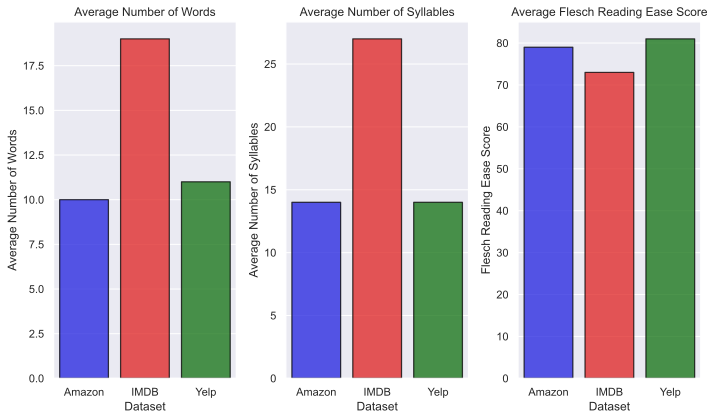

In [16]:
# Visualize the statistics
plt.figure(figsize=(10, 6))

# Plot Average Number of Words
plt.subplot(1, 3, 1)
sns.barplot(x='Dataset', y='Average Number of Words', data=statistics_df,
            palette=colors, edgecolor='black', linewidth=1.25, alpha=.75, order=dataset_names)
plt.title('Average Number of Words')
plt.xlabel('Dataset')
plt.ylabel('Average Number of Words')

# Plot Average Number of Syllables
plt.subplot(1, 3, 2)
sns.barplot(x='Dataset', y='Average Number of Syllables', data=statistics_df,
            palette=colors, edgecolor='black', linewidth=1.25, alpha=.75, order=dataset_names)
plt.title('Average Number of Syllables')
plt.xlabel('Dataset')
plt.ylabel('Average Number of Syllables')

# Plot Average Flesch Reading Ease Score
plt.subplot(1, 3, 3)
sns.barplot(x='Dataset', y='Average Flesch Reading Ease Score', data=statistics_df,
            palette=colors, edgecolor='black', linewidth=1.25, alpha=.75, order=dataset_names)
plt.title('Average Flesch Reading Ease Score')
plt.xlabel('Dataset')
plt.ylabel('Flesch Reading Ease Score')

plt.tight_layout()
plt.show()

**Observations**
- **Review Length:** IMDB reviews are noticeably longer on average compared to Amazon and Yelp reviews. This could indicate that users on IMDB tend to provide more detailed feedback.<br>
- **Syllables:** The average number of syllables per review correlates with the number of words, indicating that longer reviews naturally have more syllables.<br>
- **Reading Ease:** Yelp reviews are the easiest to read, followed by Amazon reviews, with IMDB reviews being the most complex. The Flesch Reading Ease Scores indicate that all reviews are generally easy to read, but IMDB reviews require slightly higher reading proficiency.<br><br>

**Readability Relevance**

While not the only factor, the readability of text can significantly impact the ease of sentiment prediction for several reasons:

- **Clarity and Simplicity:**
Highly readable text tends to express sentiment more explicitly and with less ambiguity. Shorter sentences and more straightforward vocabulary contribute to reducing the complexity of sentiment analysis.

- **Consistent Sentence Structures:**
Readable text often exhibits more consistent and predictable sentence structures, which can aid machine learning models in effectively identifying sentiment-related patterns.

- **Reduced Noise:**
Text with higher readability scores will likely have fewer complex or convoluted expressions, minimizing noise and making sentiment analysis easier.


**Proposed Word Embedding Length:**

Each word is represented by an embedding length of 50 dimensions. This length strikes a balance between capturing semantic information and maintaining computational efficiency.

#### **Tokenization Process**

The tokenization process in natural language processing (NLP) involves converting text into tokens (words or subwords), which machine learning models can then process further. 

**The primary goals of tokenization include:**

- [x] **Standardization:** Ensure that the text data is in a uniform format, making it easier to analyze and process.
- [x] **Normalization:** Convert text to lowercase, remove punctuation, and handle special characters to reduce variability.
- **Vocabulary Management:** Create a vocabulary of unique tokens and manage out-of-vocabulary (OOV) words effectively.
- **Text Simplification:** Break down complex text data into smaller, manageable parts (tokens) to facilitate further analysis.
- **Numerical Representation:** Convert text into numerical format (sequences of integers) that can be fed into machine learning models.

In [17]:
def tokenize_texts(texts,):
    tokenizer = Tokenizer(oov_token='<UNK>')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    return sequences, tokenizer

data = df.copy()
# Tokenize the texts
sequences, tokenizer = tokenize_texts(df['cleaned_reviews'])

#### **Maximum Sequence Length**

The maximum sequence length is the longest sequence of words or sentences considered. Sequences longer than this are cut off, while shorter ones are extended to maintain consistent input size for the model. This ensures uniform input sequence lengths for batch processing in neural networks. The 95th percentile of the sequence lengths determines the maximum length, effectively covering most data while mitigating the impact of overly long sequences.

In [18]:
# Calculate the lengths of the sequences
sequence_length = [len(seq) for seq in sequences]

# Add the sequence lengths to the DataFrame
data['sequence_length'] = sequence_length


Average sequence length per site:
     site       mean  median        std  count
0  Amazon  10.454545     9.0   6.789144    990
1    IMDB  19.735570    13.0  64.385254    745
2    Yelp  11.060241    10.0   6.310109    996




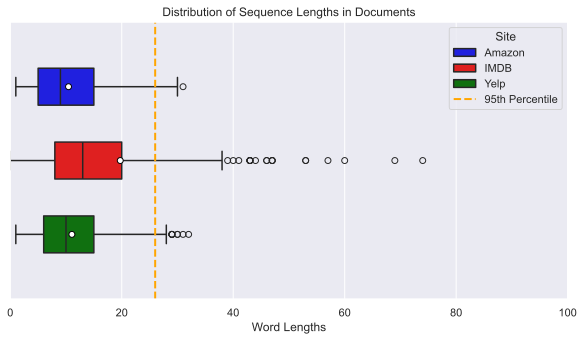

In [19]:
# Group by site and calculate statistics
site_stats = data.groupby('site')['sequence_length'].agg(
    ['mean', 'median', 'std', 'count']).reset_index()

print(f'\nAverage sequence length per site:\n{site_stats}\n\n')

# Create a boxplot of word lengths
plt.figure(figsize=(10, 5))
sns.boxplot(x=sequence_length, hue=df['site'], gap=0.5, palette=colors, linewidth=1.5, showmeans=True, meanprops={
            "marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"})

plt.xlim(0, 100)
plt.axvline(x=np.percentile(sequence_length, 95), color='orange',
            linestyle='--', label='95th Percentile', linewidth=2)

plt.title('Distribution of Sequence Lengths in Documents')
plt.legend(title='Site')
plt.xlabel('Word Lengths')
plt.show()

**Insights**

- **IMDB's Higher Variation:** IMDB has a high standard deviation, indicating a wide range of sequence lengths. The boxplot shows many outliers. This variation may be because some users write detailed reviews while others write short ones.

- **Amazon and Yelp Similarity:** Amazon and Yelp have similar mean, median, and standard deviation values. This indicates that the length of reviews on these platforms is more consistent and less varied than IMDB.

- **Data Distribution:** Comparing the mean and median for all sites reveals a skewed distribution of sequence lengths. For example, IMDB's mean (19.74) significantly exceeds its median (13.0), illustrating a right-skewed distribution with some exceptionally long sequences.

In [20]:
Q1 = data['sequence_length'].quantile(0.25)
Q3 = data['sequence_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
cleaned_sequence_lengths = data[(data['sequence_length'] >= lower_bound) & (
    data['sequence_length'] <= upper_bound)]['sequence_length']

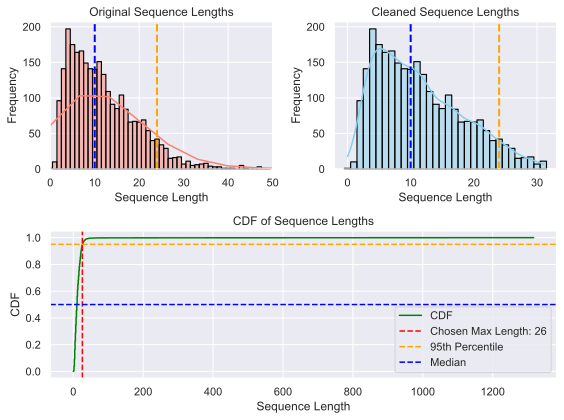

Optimal maximum sequence length for 95% coverage with outliers: 26
Optimal maximum sequence length for 95% coverage without outliers: 24


In [21]:
# Calculate the CDF
sequence_lengths_sorted = np.sort(sequence_length)
cdf = np.arange(1, len(sequence_lengths_sorted) + 1) / \
    len(sequence_lengths_sorted)
cumulative_distribution = [sum([1 for length in sequence_lengths_sorted if length <= i]) / len(
    sequence_lengths_sorted) for i in range(max(sequence_lengths_sorted) + 1)]
cleaned_cumulative_distribution = [sum([1 for length in cleaned_sequence_lengths if length <= i]) / len(
    cleaned_sequence_lengths) for i in range(max(cleaned_sequence_lengths) + 1)]

label = f'Chosen Max Length: {round(np.percentile(sequence_length, 95))}'

# Calculate number of bins
num_bins_sequence_lengths = int(np.sqrt(len(sequence_length)))

# Create a figure with subplot mosaic
fig, ax = plt.subplot_mosaic(
    """
    AB
    CC
    """,
    figsize=(8, 6)
)

# Original sequence length distribution
sns.histplot(data['sequence_length'], bins=num_bins_sequence_lengths, color='salmon',
             discrete=True, edgecolor='black', kde=True, linewidth=1.15, ax=ax['A'])
ax['A'].axvline(x=np.percentile(cleaned_sequence_lengths, 95),
                color='orange', linestyle='--', label='95th Percentile', linewidth=2)
ax['A'].axvline(x=np.percentile(cleaned_sequence_lengths, 50),
                color='blue', linestyle='--', label='Median', linewidth=2)
ax['A'].set_title('Original Sequence Lengths')
ax['A'].set_xlabel('Sequence Length')
ax['A'].set_ylabel('Frequency')
ax['A'].set_xlim(0, 50)  # Adjusted range for better visualization

# Cleaned sequence length distribution
sns.histplot(cleaned_sequence_lengths, bins=num_bins_sequence_lengths, color='skyblue',
             discrete=True, edgecolor='black', kde=True, linewidth=1.15, ax=ax['B'])
ax['B'].axvline(x=np.percentile(cleaned_sequence_lengths, 95),
                color='orange', linestyle='--', label='95th Percentile', linewidth=2)
ax['B'].axvline(x=np.percentile(cleaned_sequence_lengths, 50),
                color='blue', linestyle='--', label='Median', linewidth=2)
ax['B'].set_title('Cleaned Sequence Lengths')
ax['B'].set_xlabel('Sequence Length')
ax['B'].set_ylabel('Frequency')


# Plot CDF of sequence lengths
ax['C'].plot(sequence_lengths_sorted, cdf, color='green', label='CDF')
ax['C'].set_title('CDF of Sequence Lengths')
ax['C'].axvline(x=np.percentile(sequence_length, 95),
                color='red', linestyle='--', label=label)
ax['C'].axhline(y=0.95, color='orange', linestyle='--',
                label='95th Percentile')
ax['C'].axhline(y=0.5, color='blue', linestyle='--', label='Median')
ax['C'].set_xlabel('Sequence Length')
ax['C'].set_ylabel('CDF')
ax['C'].legend()

plt.tight_layout()
plt.show()

# Find the maximum sequence length for 95% coverage
optimal_length = next(i for i, cumulative in enumerate(
    cumulative_distribution) if cumulative >= 0.95)
print(
    f"Optimal maximum sequence length for 95% coverage with outliers: {optimal_length}")

# find the maximum sequence length for 95% coverage after cleaning
cleaned_optimal_length = next(i for i, cumulative in enumerate(
    cleaned_cumulative_distribution) if cumulative >= 0.95)
print(
    f"Optimal maximum sequence length for 95% coverage without outliers: {cleaned_optimal_length}")

#### **Statistical Justification for Maximum Sequence Length**

The graph compares sentence lengths before and after removing outliers. The 95th percentile length only decreases by two after outlier removal, indicating that 26 is an appropriate maximum sequence length. The CDF plot shows that 95% of the sequences are covered by the length of 26, suggesting high coverage and minimal impact of outliers. This choice provides a good balance between coverage and computational efficiency.

### Padding Process
Padding is essential to ensure all sequences are uniform, which is required for batch processing in neural networks. Without padding, sequences of varying lengths cannot be processed together, leading to inconsistencies and inefficiencies.

**Steps in the Padding Process:**
- [x] **Determine Maximum Sequence Length:** Decide the maximum length for sequences based on the data distribution or model requirements.
- [ ] **Pad Sequences:** Add padding tokens to sequences shorter than the maximum length. If necessary, truncate sequences that are longer than the maximum length.

**Pre-padding:** This involves adding tokens before the text sequence. Pre-padding is common in many neural network architectures, including RNNs, LSTMs, and GRUs, where the sequence is processed from start to end.

**Post-padding:** This involves adding tokens after the text sequence. Post-padding is often used in Transformer models and attention mechanisms because it keeps the more informative part of the sequence at the beginning, which can improve performance in text classification.

In [22]:
pre_padded_sequences = pad_sequences(sequences, maxlen=26, padding='pre')
post_padded_sequences = pad_sequences(sequences, maxlen=26, padding='post')

In [23]:
# Examples of cleaned, tokenized, and padded text
print("\nCleaned, Tokenized, and Padded Text Examples:")
print(f"Original: {df['review'][1]}")
print(f"Cleaned: {df['cleaned_reviews'][1]}")
print(f"Tokenized and Pre-Padded: {pre_padded_sequences[1]}\n")
print(f"Tokenized and Post-Padded: {post_padded_sequences[1]}\n")


Cleaned, Tokenized, and Padded Text Examples:
Original: Good case, Excellent value.
Cleaned: good case excellent value
Tokenized and Pre-Padded: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  20 152  98 514]

Tokenized and Post-Padded: [ 20 152  98 514   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]



### 4. Sentiment Categories and Activation Function
**Sentiment Categories:** 
 - Positive (1)
 - Negative (0)

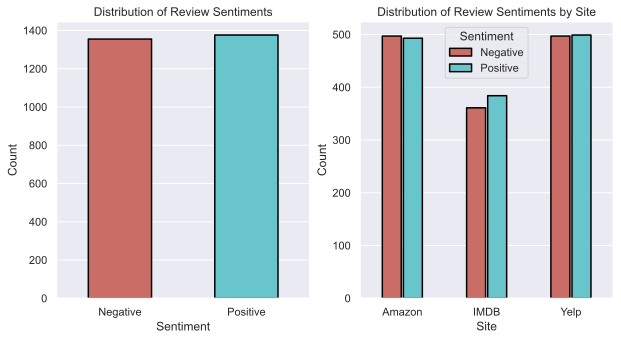

In [24]:
plt.figure(figsize=(10, 5))

# visualize the distribution of review sentiments
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='sentiment', palette='hls',
              edgecolor='black', linewidth=1.5, width=0.5,)
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.ylabel('Count')


# Analyzing the distribution of review sentiments by site
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='site', hue='sentiment', palette='hls',
              edgecolor='black', linewidth=1.5, width=0.5, gap=0.1)
plt.title('Distribution of Review Sentiments by Site')
plt.xlabel('Site')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])
plt.show()

In [25]:
# Distribution of sentiments by site
site_sentiment_counts = data.groupby(
    ['site', 'sentiment']).size().unstack(fill_value=0)
site_sentiment_proportions = data.groupby(['site', 'sentiment']).size().groupby(
    level=0).apply(lambda x: x / x.sum()).unstack(fill_value=0) * 100

print("Count of each sentiment by site:")
print(site_sentiment_counts)

print("\nProportion of each sentiment by site:")
print(site_sentiment_proportions)

Count of each sentiment by site:
sentiment    0    1
site               
Amazon     497  493
IMDB       361  384
Yelp       497  499

Proportion of each sentiment by site:
sentiment              0          1
site   site                        
Amazon Amazon  50.202020  49.797980
IMDB   IMDB    48.456376  51.543624
Yelp   Yelp    49.899598  50.100402


#### Data Preparation Steps

**Splitting the Data:**

The data is split into training (70%), validation (15%), and test (15%) sets to facilitate model training and evaluation.

In [26]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

max_words = len(tokenizer.word_index)
max_sequence_length = 26
X = pre_padded_sequences
y = df['sentiment']

# Split data consistently
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

## Part III: Network Architecture
### Network Description
#### Model Summary

In [27]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=max_words+1,  # Vocabulary size plus one for the OOV token
        output_dim=50,          # Embedding dimension
        input_length=max_sequence_length  # Input sequence length
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        units=32,               # Number of LSTM units
        dropout=0.4,            # Dropout rate for inputs
        recurrent_dropout=0.2   # Dropout rate for recurrent state
    )),
    tf.keras.layers.Dense(
        units=24,               # Number of neurons in dense layer
        activation='relu'       # Activation function
    ),
    tf.keras.layers.Dropout(0.3),  # Dropout rate
    tf.keras.layers.Dense(
        units=12,               # Number of neurons in second dense layer
        activation='relu'       # Activation function
    ),
    tf.keras.layers.Dense(
        units=1,                # Single neuron for binary output
        activation='sigmoid',   # Sigmoid activation for binary classification
        kernel_regularizer=l2(0.002)  # L2 regularization
    )
])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)


# Early stopping to halt training when validation loss increases
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', patience=2, restore_best_weights=True)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='binary_crossentropy', metrics=['accuracy'])

**Layers and Parameters**
- **Layers:**

    - **Embedding Layer:** The embedding layer converts encoded words into fixed-size (50 dimensions) dense vectors.
        - **Parameters:**
            - `max_words+1`: The size of the vocabulary. Adding 1 for an out-of-vocabulary (OOV) token.
            - `output_dim=50`: The dimensionality of the embedding vectors. A 50-dimensional vector represents each word.
            - `input_length=max_sequence_length`: The length of input sequences. All input sequences are expected to be of this length after padding.
              
    - **Bidirectional LSTM Layer:** The Bidirectional LSTM processes input sequences forward and backward, allowing the model to capture dependencies and context from previous and future data. This is particularly useful for detecting sentiment in text, where context is key.
      
        - **Parameters:**
            - `32`: The number of units in the LSTM layer determines the dimensionality of the output space.
            - `dropout=0.4`: The dropout rate applied to the LSTM layer prevents overfitting by randomly setting 40% of the LSTM units to zero during training.
            - `recurrent_dropout=0.2`: The dropout rate is applied to the recurrent state of the LSTM units, adding regularization to the memory cells.
          
    - **Dense Layers:** These layers apply a fully connected operation, where each node is connected to every node in the previous layer. The dense layers allow the model to learn complex patterns and interactions between the features extracted by the previous LSTM layer.
        - **Parameters:**
            - **First Dense Layer:**
                - `24`: Number of neurons representing the output space dimensionality.
                - `activation='relu'`: The ReLU activation function adds non-linearity, allowing the model to understand complex functions.
            - **Dropout Layer:**
                - `0.3`: Dropout rate applied to the first dense layer, where 30% of the neurons are randomly set to zero during training to prevent overfitting.
        - **Second Dense Layer:**
            - `12`: Number of neurons in the layer.
            - `activation='relu'`: The ReLU activation function continues to introduce non-linearity in the model.
    - **Output Layer:** The output layer provides the final prediction of the model for a binary classification problem. It uses a single neuron with a sigmoid activation function to produce a value between 0 and 1. This indicates the likelihood of the input belonging to the positive class.
        - **Parameters:**
            - `1`: The number of neurons is set to 1, as the task is binary classification.
            - `activation='sigmoid'`: The sigmoid activation function maps the output to a probability value.
            - `kernel_regularizer=l2(0.002)`: L2 regularization is applied to the kernel weights to discourage large weights and help prevent overfitting by adding a penalty for larger weights.

In [28]:
# Build the model by providing input shape
model.build(input_shape=(None, max_sequence_length))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 26, 50)         │       252,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,021 (1.05 MB)

 Trainable params: 276,021 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

#### Model Summary Details
**Embedding Layer:**

```
Layer (type): embedding (Embedding)
Output Shape: (None, 26, 50)
Param #: 252,900
```
 - Output Shape: (None, 26, 50) indicates that each input sequence of length 26 is converted into a sequence of 50-dimensional vectors. None represents the batch size, which can vary.
- Parameters: 252,900 parameters calculated as (vocabulary size + 1) * embedding dimension = (5049 + 1) * 50.
  
**Bidirectional LSTM Layer:**


```
Layer (type): bidirectional (Bidirectional)
Output Shape: (None, 64)
Param #: 21,248
```

- Output Shape: (None, 64) indicates that it outputs a vector of size 64 for each input sequence.
- Parameters: 21,248 parameters. For an LSTM layer with `n` units, parameters include weights and biases for input, output, forget, and cell gates. The formula is `4 * ((units + input_dim + 1) * units)` and doubled for bi-directionality.

**First Dense Layer:**

```
Layer (type): dense (Dense)
Output Shape: (None, 24)
Param #: 1,560
```

- Output Shape: (None, 24) outputs a 24-dimensional vector for each input.
- Parameters: 1,560 parameters, calculated as input_dim * units + units = 64 * 24 + 24.

**Dropout Layer:**

```
Layer (type): dropout (Dropout)
Output Shape: (None, 24)
Param #: 0
```

- Output Shape: (None, 24) remains unchanged as dropout only affects training, not the structure.
- Parameters: 0 parameters since dropout does not have learnable parameters.

**Second Dense Layer:**
```
Layer (type): dense_1 (Dense)
Output Shape: (None, 12)
Param #: 300
```

- Output Shape: (None, 12) outputs a 12-dimensional vector.
- Parameters: 300 parameters, calculated as 24 * 12 + 12.
  
**Output Dense Layer:**
```
Layer (type): dense_2 (Dense)
Output Shape: (None, 1)
Param #: 13
```

- Output Shape: (None, 1) outputs a single value per input sequence.
- Parameters: 13 parameters, calculated as 12 * 1 + 1.

**Total Parameters**

```
Total params: 276,021
Trainable params: 276,021
Non-trainable params: 0
````

This summary shows the model's architecture, transforming input data through multiple layers to produce a binary classification output. Each layer's parameters contribute to the model's capacity to learn and generalize from the data.

### Hyperparameter Justification

**Activation Functions**

- **ReLU (Rectified Linear Unit)**
    - **Justification:** ReLU is used in intermediate dense layers to introduce non-linearity, enabling the model to learn complex patterns efficiently.

- **Sigmoid**
    - **Justification:** Sigmoid is used in the output layer to map the output to a probability value between 0 and 1, ideal for binary classification tasks like sentiment analysis.

**Number of Nodes**

- **Justification:** The number of nodes in each layer is chosen based on the complexity of the data and the need for model capacity, providing a balance between learning capability and computational efficiency. Having a sufficient number of nodes allows the model to capture necessary features and patterns from the data without overfitting

**Loss Function**

- **Binary Cross-Entropy**
    - **Justification:** It is the standard loss function for binary classification tasks, measuring the difference between predicted probabilities and actual class labels and penalizing incorrect predictions more heavily.

**Optimizer**

- **Adam (Adaptive Moment Estimation)**
    - **Justification:** Adam optimizer is chosen for its efficiency and adaptability, providing fast convergence with minimal tuning.

**Stopping Criteria**

- **Early Stopping:**
    - **Justification:** This method is implemented to prevent overfitting by halting training once the validation loss stops improving for a specified number of epochs, optimizing training efficiency and model performance.

**Evaluation Metric**

- **Accuracy**
    - **Justification:** Used as the primary evaluation metric for its straightforward measure of the model's performance on the validation set.

**Conclusion:**

Each hyperparameter and architectural choice in the model is tailored to address the specific needs of sentiment analysis, balancing complexity, efficiency, and performance.

In [29]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4862 - loss: 0.6965 - val_accuracy: 0.5122 - val_loss: 0.6957 - learning_rate: 5.0000e-05
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4948 - loss: 0.6958 - val_accuracy: 0.5000 - val_loss: 0.6956 - learning_rate: 5.0000e-05
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5143 - loss: 0.6958 - val_accuracy: 0.4976 - val_loss: 0.6955 - learning_rate: 5.0000e-05
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5270 - loss: 0.6954 - val_accuracy: 0.5390 - val_loss: 0.6953 - learning_rate: 5.0000e-05
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5343 - loss: 0.6951 - val_accuracy: 0.5659 - val_loss: 0.6950 - learning_rate: 5.0000e-05
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5425 - loss: 0.6947 - val_accuracy: 0.5780 - val_loss: 0.6947 - learning_rate: 5.0000e-05
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5448 - loss

**Saving the model**

*Note: The HDF5 format is now considered legacy. Below is the code to save in either format. Uncomment the preferred format to save.*

In [30]:
# Save the model to an HDF5 file
# model.save('model.h5')
# Save the model in the native Keras format
# model.save('my_model.keras')

**Prepared Dataset**
- Separate data frames were created for the training, validation, and test sets. Then, they were combined into a single `DataFrame` using the `pd.concat()` function.
- Next, a column (`set_type`) was added to indicate whether each row belongs to the training, validation, or test set.
- The entire dataset is saved in a single CSV file named `full_dataset.csv.`

In [31]:
# # Convert labels to numpy arrays
# y_train = np.array(y_train)
# y_val = np.array(y_val)
# y_test = np.array(y_test)

# # Create DataFrames for each set with a 'set_type' column
# train_df = pd.DataFrame(X_train, columns=[f'feature_{i+1}' for i in range(max_sequence_length)])
# train_df['label'] = y_train
# train_df['set_type'] = 'train'

# val_df = pd.DataFrame(X_val, columns=[f'feature_{i+1}' for i in range(max_sequence_length)])
# val_df['label'] = y_val
# val_df['set_type'] = 'validation'

# test_df = pd.DataFrame(X_test, columns=[f'feature_{i+1}' for i in range(max_sequence_length)])
# test_df['label'] = y_test
# test_df['set_type'] = 'test'

# # Concatenate all DataFrames into one
# full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# # Save the full DataFrame to a single CSV file
# full_df.to_csv('full_dataset.csv', index=False)

## Part IV: Model Evaluation
###  Training Process and Outcomes

**Impact of Stopping Criteria:**

Early stopping was set with a patience of 2 epochs, meaning training stopped if validation loss did not improve for 2 consecutive epochs. This ensured efficient use of computational resources and prevented overfitting.

**Analysis of Training Results**
- **Initial Phase (Epochs 1-10):**
  - **Accuracy and Loss:**
    - **Training Accuracy:** Starts at 48.62% and gradually improves.
    - **Validation Accuracy:** Starts at 51.22% and shows slight improvements.
    - **Loss:** The loss values decrease slightly but remain around 0.69, which is expected in the initial training phase as the model begins to learn the data distribution.<br><br>
- **Mid-Phase (Epochs 11-20):**
  - **Accuracy and Loss:**
    - **Training Accuracy:** Improves to around 78.43%.
    - **Validation Accuracy:** Increases to approximately 72.68%, indicating consistent learning.
    - **Loss:** Both training and validation losses decrease, indicating that the model is fitting the data well.<br><br>
- **Convergence and Stabilization (Epochs 21-35):**
  - **Accuracy and Loss:**
    - **Training Accuracy:** Reaches 92.43%, showing strong learning.
    - **Validation Accuracy:** Peaking at 77.32%, indicating good generalization.
    - **Loss:** The validation loss stabilizes, with minor fluctuations around 0.52, suggesting that the model has started to converge.

#### **Model Fitness and Overfitting**

In [32]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8152 - loss: 0.4137 
Test Accuracy: 0.81


The model achieved an overall accuracy of 81% with a validation loss of 0.41, indicating good generalization. Dropout and L2 regularization minimized overfitting.

#### **Visualizations**

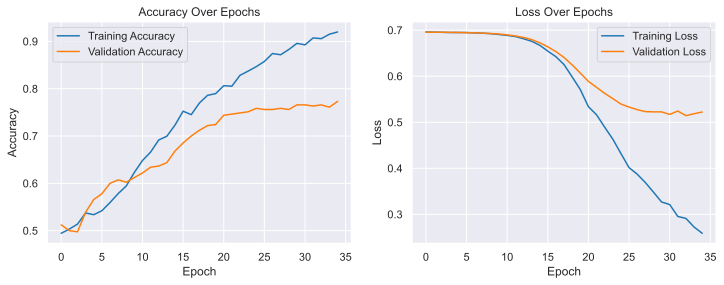

In [33]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Part V: Summary and Recommendations

## Functionality of the Neural Network

The neural network is built to analyze text and decide whether the sentiment is positive or negative. It uses a Bidirectional LSTM architecture to understand the sequence of words effectively. The embedding layer converts words into dense vector representations, which helps the model understand the meaning of the words in the context. The Bidirectional LSTM processes input sequences in both forward and backward directions to understand the context of preceding and following words in a sentence. Dense layers enable non-linear transformations to improve the accuracy of predictions. The dropout layer prevents overfitting by randomly setting input units to zero during training. The output layer uses a sigmoid activation function for binary classification, producing a value between 0 and 1. Overall, this architecture utilizes deep learning to capture the nuances of sentiment in text effectively.

## Recommendations

1. Implement sentiment analysis into customer feedback systems to respond swiftly to negative feedback and improve customer satisfaction and retention.

2. Analyze sentiment trends to guide product development and service enhancements.

3. Tailor marketing campaigns using sentiment analysis insights to improve conversion rates and brand perception.

4. Use sentiment analysis to monitor brand reputation and mitigate potential PR crises.

5. Apply sentiment analysis to competitor reviews to inform strategic positioning and capture market share.
   
By following these recommendations, we can utilize sentiment analysis to enhance customer experience, improve product offerings, and drive growth.

## References
- Kotzias, Dimitrios. (2015). Sentiment Labelled Sentences. UCI Machine Learning Repository. [https://doi.org/10.24432/C57604](https://doi.org/10.24432/C57604)